***

<center><u><H1>Generative Adversarial Networks</H1></u></center>

***

***
# Il dataset

Questo esempio di GAN è ispirato al codice messo a disposizione da TensorFlow a [questo link](https://www.tensorflow.org/tutorials/generative/dcgan). 

Il dataset è, come per l'esempio di CNN, [MNIST](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology), composto da moltissime immagini con numeri scritti a mano e molto utilizzato appunto per elaborare diverse CNN.

Anche questo dataset è disponibile nel modulo [keras.datasets](https://keras.io/api/datasets/) e possiamo caricarlo tramite il metodo [load_data()](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data):

In [1]:
import matplotlib.pyplot as plt

Per importare il dataset, possiamo direttamente accedere al modulo [keras.datasets](https://keras.io/api/datasets/) e caricarlo nel nostro codice:

In [2]:
from keras.datasets import mnist

Abbiamo a tutti gli effetti importato un modulo. Per leggere i dati, già divisi in train e test set da Keras, è sufficiente utilizzare il metodo [load_data()](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data):

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Il metodo load_data() fornisce in uscita una tupla di array NumPy con due elementi: il primo per il training set ed il secondo per il test set. Ogni elemento contiene le immagini e le label come array NumPy. Quindi train_images e test_images contengono le immagini, mentre train_labels e test_labels contengono un indice numerico che rappresenta la classe:

In [4]:
print(f"Train set: type = {type(train_images)}, shape = {train_images.shape}, data type = {train_images.dtype}")
print(f"Test set: type = {type(test_images)}, shape = {test_images.shape}, data type = {test_images.dtype}")

Train set: type = <class 'numpy.ndarray'>, shape = (60000, 28, 28), data type = uint8
Test set: type = <class 'numpy.ndarray'>, shape = (10000, 28, 28), data type = uint8


Vediamo come i dati siano degli array di valori uint8, ovvero interi compresi tra 0 e 255. Le immagini hanno dimensione $28\times 28$. Per quanto riguarda le label, questa volta sono memorizzate come NumPy array e non occorre una doppia indicizzazione per accedere ai valori. Essendo un dataset di immagini per riconoscere delle cifre da 0 a 9, chiaramente le classi corrispondono alla cifra da predire:

In [5]:
import numpy as np
print(np.unique(train_labels))
print(train_labels[3])

[0 1 2 3 4 5 6 7 8 9]
1


Verifichiamo che il dataset sia stato importato correttamente mostrando le prime 25 immagini (si ricorda che range parte di default da 0 ed esclude il valore indicato come stop):

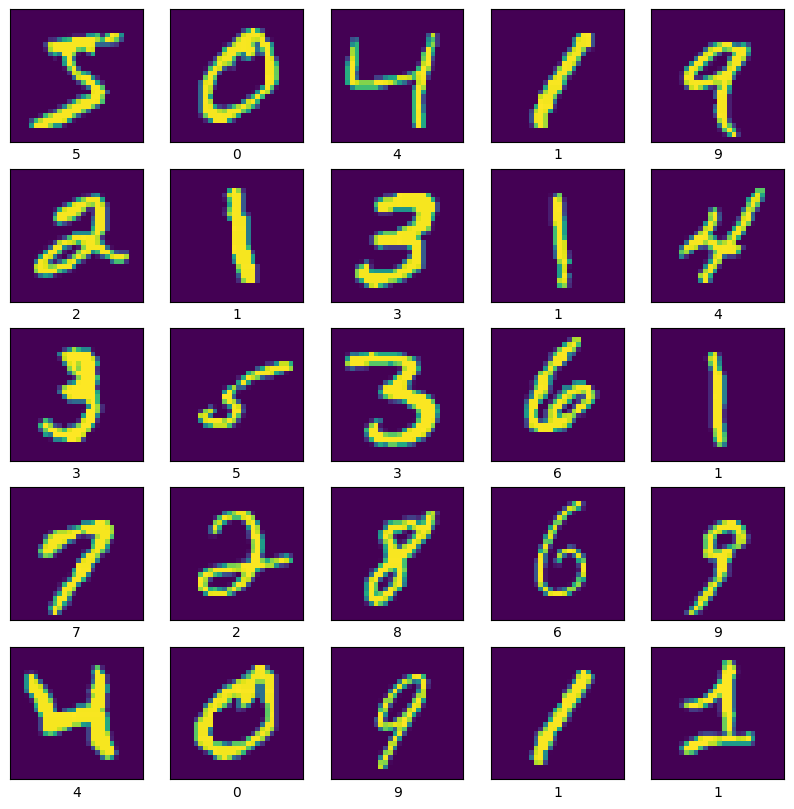

In [6]:
plt.figure(figsize=(10,10))
for fig_index in range(25):
    plt.subplot(5, 5, fig_index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[fig_index])
    plt.xlabel(train_labels[fig_index])
plt.show()

Questo esempio mostra come generare delle immagini che emulano la scrittura umana basandosi sul dataset MNIST, andando ad implementare una Deep Convolutional GAN (DCGAN).

## Importazione dei moduli

I moduli aggiuntivi, rispetto ai soliti, che sono necessari per questo notebook sono i seguenti:
- [**glob**](https://docs.python.org/3/library/glob.html): permette di definire delle ricerche sul path dei file;
- [**os**](https://docs.python.org/3/library/os.html): fornisce dei tool per la navigazione del fyle system e apertura/scrittura di file;
- [**PIL**](https://pypi.org/project/pillow/): per aspetti di image processing;
- [**time**](https://docs.python.org/3/library/time.html): per operazioni che coinvolgono il calcolo o elaborazione dei tempi di esecuzione;
- [**IPython**](https://ipython.org): per il notebook e alcune funzioni di visualizzazione avanzate.

In [7]:
import tensorflow as tf
from keras import layers, Sequential, Input
import glob
import imageio
import os
import PIL
import time
from IPython import display

## Preparazione del dataset

Per prima cosa, andiamo a cambiare la forma dell'array (aggiungendo una dimensione) che contiene le immagini del training set (il dataset su cui lavoreremo) e a rendere i suoi input dei float a 32 bit.

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

Ora scaliamo i dati. A differenza del riconoscimento di immagini, scaliamo i valori dei pixel per portarli tra -1 e 1. Questo perché il generatore della nostra GAN lavorerà con una tangente iperbolica come funzione di attivazione, una pratica comune in questo tipo di reti. Dato che i valori sono compresi tra 0 e 255, è sufficiente sottrarre 127.5 e poi dividere per lo stesso valore:

In [9]:
train_images = (train_images - 127.5) / 127.5

Definiamo le dimensioni del buffer delle immagini e del batch con cui andremo ad addestrare la rete. Come vedremo, per le GAN andremo a scrivere un codice che ci permette di addestrare un batch alla volta in modo esplicito:

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

Una volta definito il buffer delle immagini e le dimensioni del batch, creiamo il dataset per l'addestramento:
- il metodo [from_tensor_slices()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) prende il tensore che corrisponde alle immagini e crea un oggetto dataset di TensorFlow in cui le singole slice sono le immagini;
- il metodo [shuffle](https://www.tensorflow.org/api_docs/python/tf/random/shuffle) mescola in modo pseudo-casuale le immagini (slice);
- il metodo [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) combina un dato numero di immagini consecutive e le unisce in un batch.

Combinando queste operazioni in successione, abbiamo ottenuto un dataset per l'addestramento già raggruppato in batch mescolati in modo pseudo-casuale:

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Creazione dei modelli

Ora andiamo a creare i modelli del generatore e del discriminatore.

## Generator

Il generatore utilizza dei layer [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose). Come visto nella CNN, il discriminatore andrà a classificare le immagini ricorrendo alla convoluzione 2D e al down-sampling; il generatore, invece, deve creare immagini da rumore in ingresso: occorre quindi procedere concettualmente in modo inverso, andando a sovra-campionare i dati forniti in input ad ogni step nella rete. La lista di layer completa è la seguente:
- Dense layer per l'ingresso alla rete. Per il dimensionamento, ricordiamo che abbiamo un batch size con 256 elementi; decidiamo di creare delle immagini prendendo $100$ valori pseudo-casuali in input e fornire una prima immagine intermedia di dimensione $7\times 7$. Per questo, utilizziamo $7\times 7\times 256$ neuroni;
- [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) è un layer che applica una trasformazione che mantiene l'uscita con media quasi nulla e deviazione standard unitaria. In fase di addestramento, la normalizzazione avviene lavorando sulla media e la deviazione standard del batch in ingresso;
- [LeakyReLu](https://keras.io/api/layers/activation_layers/leaky_relu/) è la ReLU parametrica in cui i valori negativi non sono resi nulli in uscita, ma modificati con un coefficiente angolare di valore $0.3$ di default;
- [Reshape](https://keras.io/api/layers/reshaping_layers/reshape/) è un layer che ci permette di convertire l'array in ingresso (siamo ancora in 1D) in un array con le dimensioni desiderate. Nel nostro caso, vogliamo lavorare inizialmente con immagini $7\times 7\times 256$ (deve chiaramente tornare con le dimensioni del Dense layer inserito prima);
- [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) è il layer che permette la convoluzione trasposta in due dimensioni. Come nelle CNN, definiamo il numero di filtri e le dimensioni del kernel.

I layer di convoluzione sono seguiti da continue normalizzazioni e LeakyReLu. L'ultima convoluzione ha un singolo neurone (l'output) e come detto in precedenza ricorriamo ad una attivazione con tangente iperbolica. Per quanto riguarda le dimensioni in uscita dal layer di convoluzione, la formula è (per immagini quadrate) $(N-1)*S-2P+(L-1)+1$. 

**assert** è una keyword che viene utilizzata in fase di debug e permette di verificare una condizione. Nel nostro caso, viene utilizzata per verificare che le dimensioni intermedie degli array nel generatore siano corrette.

In [12]:
def make_generator_model():
    """
    Questa funzione crea il generatore della GAN
    :return: modello non compilato del generatore
    """
    model = Sequential()
    model.add(Input(shape=(100, )))
    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Possiamo già utilizzare questa rete per creare un'immagine casuale: semplicemente non sarà qualcosa legato al training set che stiamo utilizzando. Da notare che, non dovendo addestrarla, non occorre compilare la rete per indicare ottimizzatore, costi e metriche. Come detto, in ingresso vengono presi dei valori dal latent space che sono numeri pseudo-casuali, solitamente distribuiti come una normale:

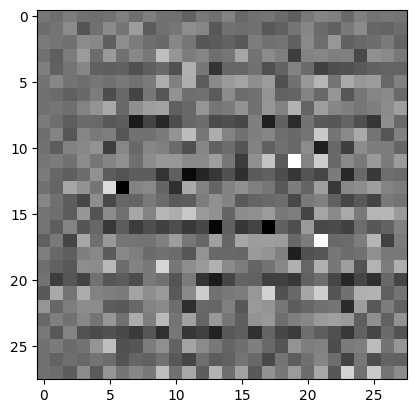

In [13]:
# creiamo il generatore
generator = make_generator_model()

# generiamo input pseudo-casuali
noise = tf.random.normal([1, 100])

# creiamo un'immagine
generated_image = generator(noise, training=False)

# mostriamo il risultato
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Effettivamente, non avendo addestrato la rete, abbiamo del rumore in uscita. Le dimensioni però sono quelle desiderate: immagini in bianco e nero $28\times 28$:

In [14]:
generated_image.shape

TensorShape([1, 28, 28, 1])

In [15]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

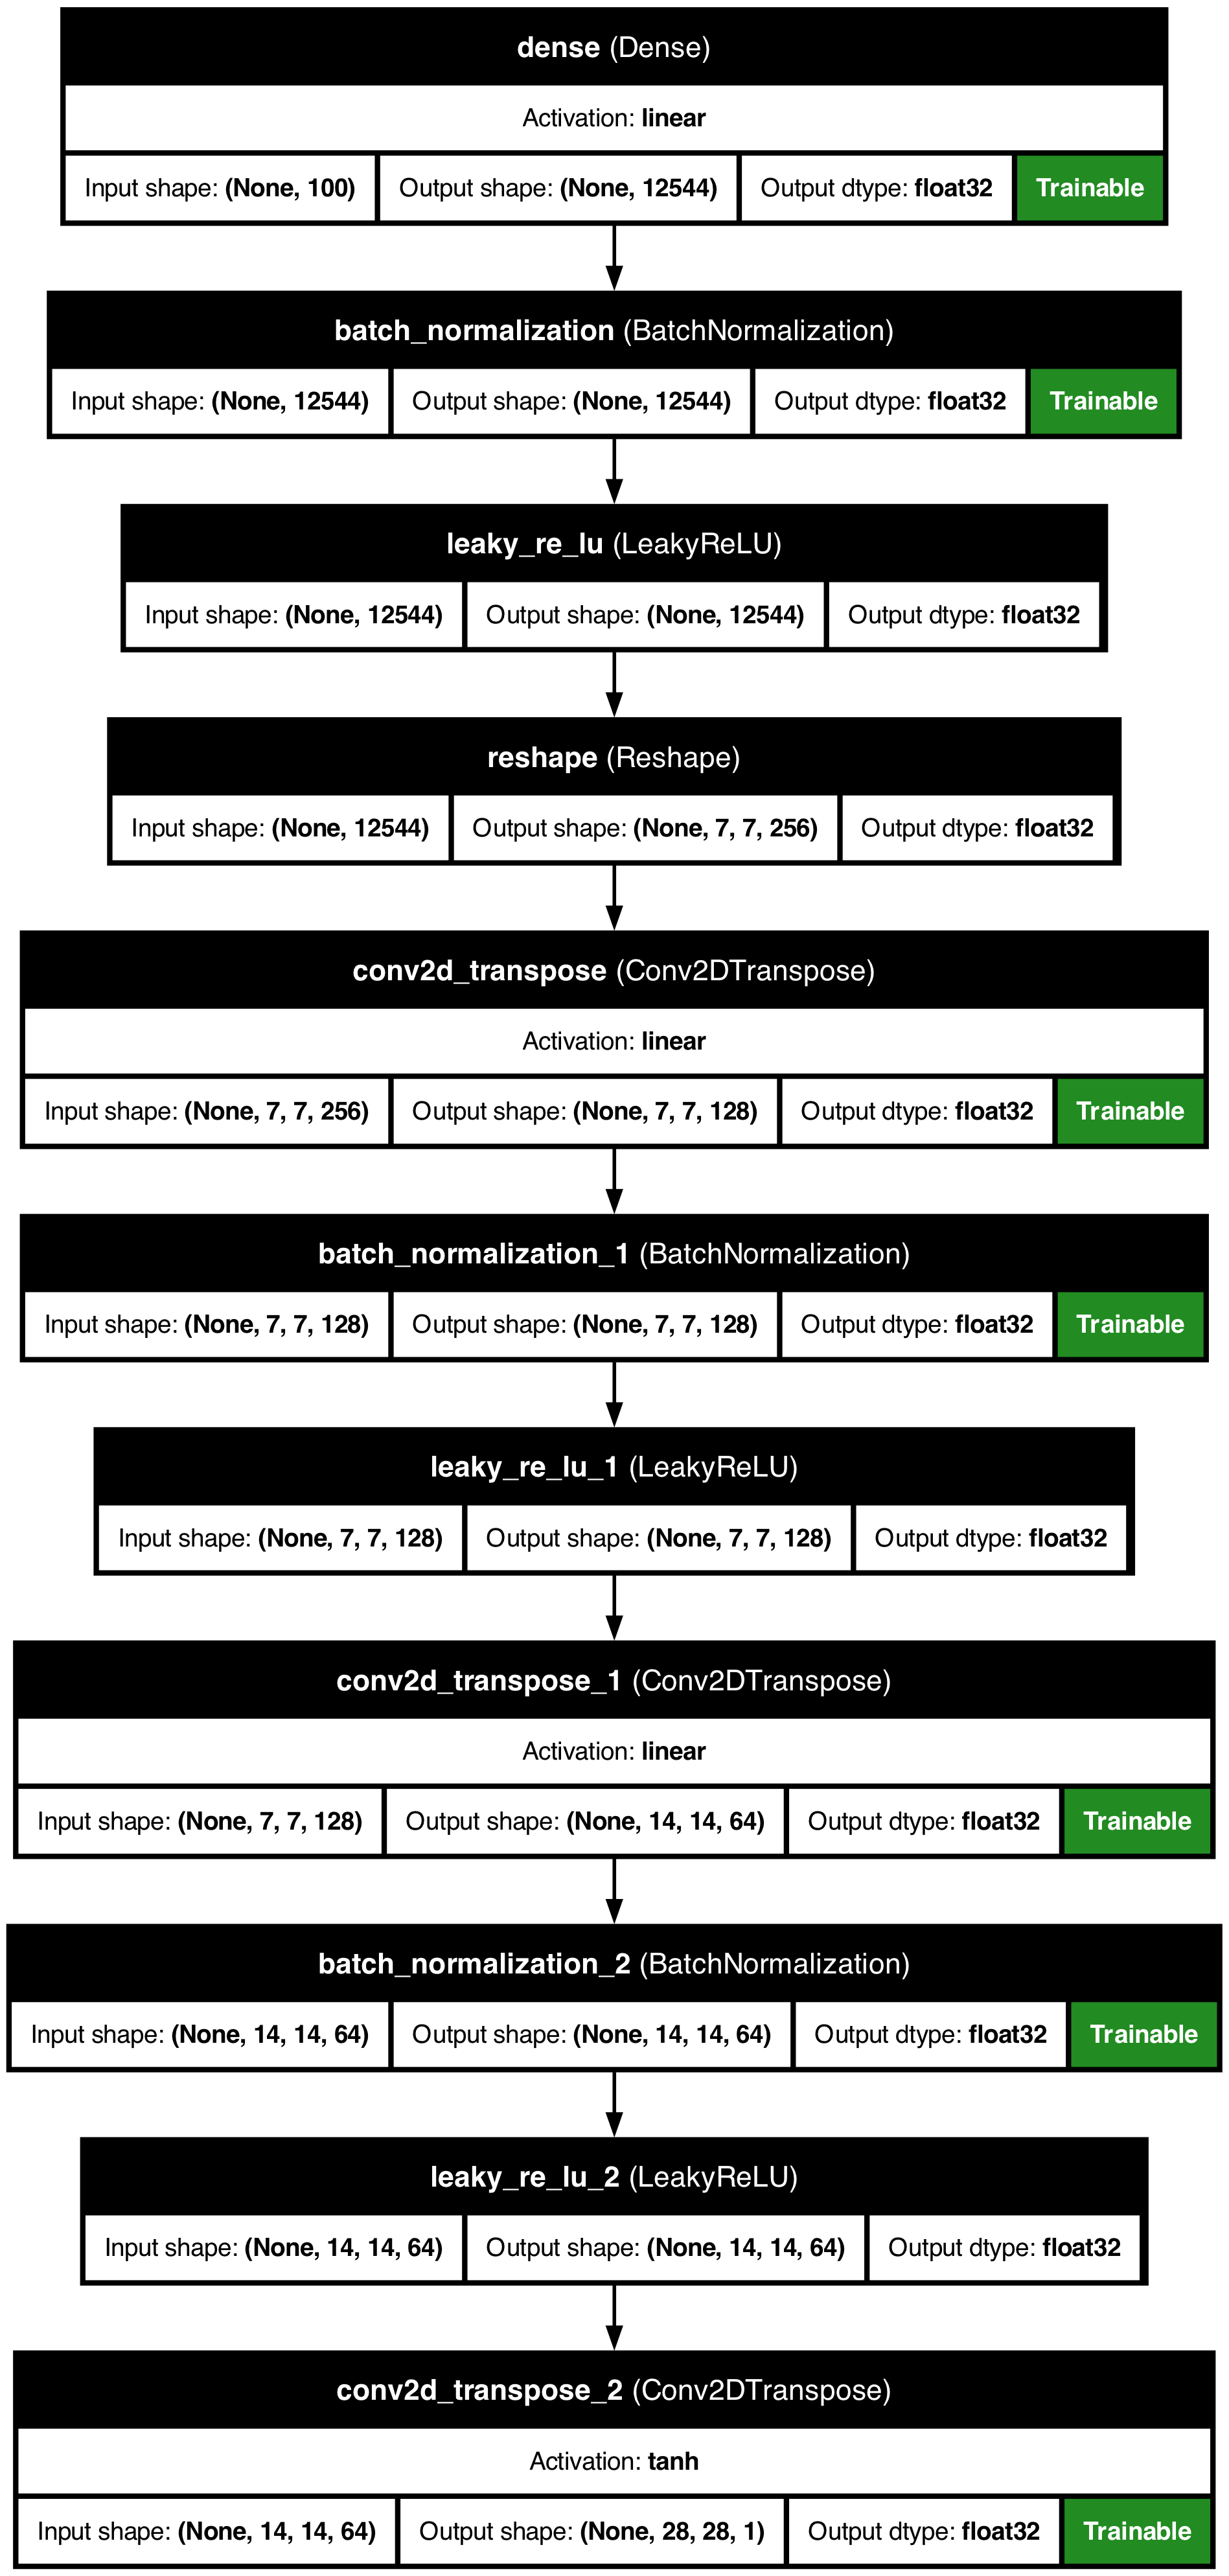

In [16]:
tf.keras.utils.plot_model(
    generator,
    rankdir='TB',
    show_shapes=True,
    show_layer_names=True,
    show_dtype=True,
    show_layer_activations=True,
    show_trainable=True
)

## Discriminator

Il discriminatore è a tutti gli effetti una CNN di classificazione di immagini:

In [17]:
def make_discriminator_model():
    """
    Questa funzione crea il discriminatore della GAN
    :return: modello non compilato del discriminatore
    """
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Anche in questo caso, possiamo già utilizzare questa rete dando in ingresso l'immagine generata prima. Non essendoci una funzione di attivazione, possiamo aspettarci uno scalare in uscita:

In [18]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00110899]], shape=(1, 1), dtype=float32)


In [19]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

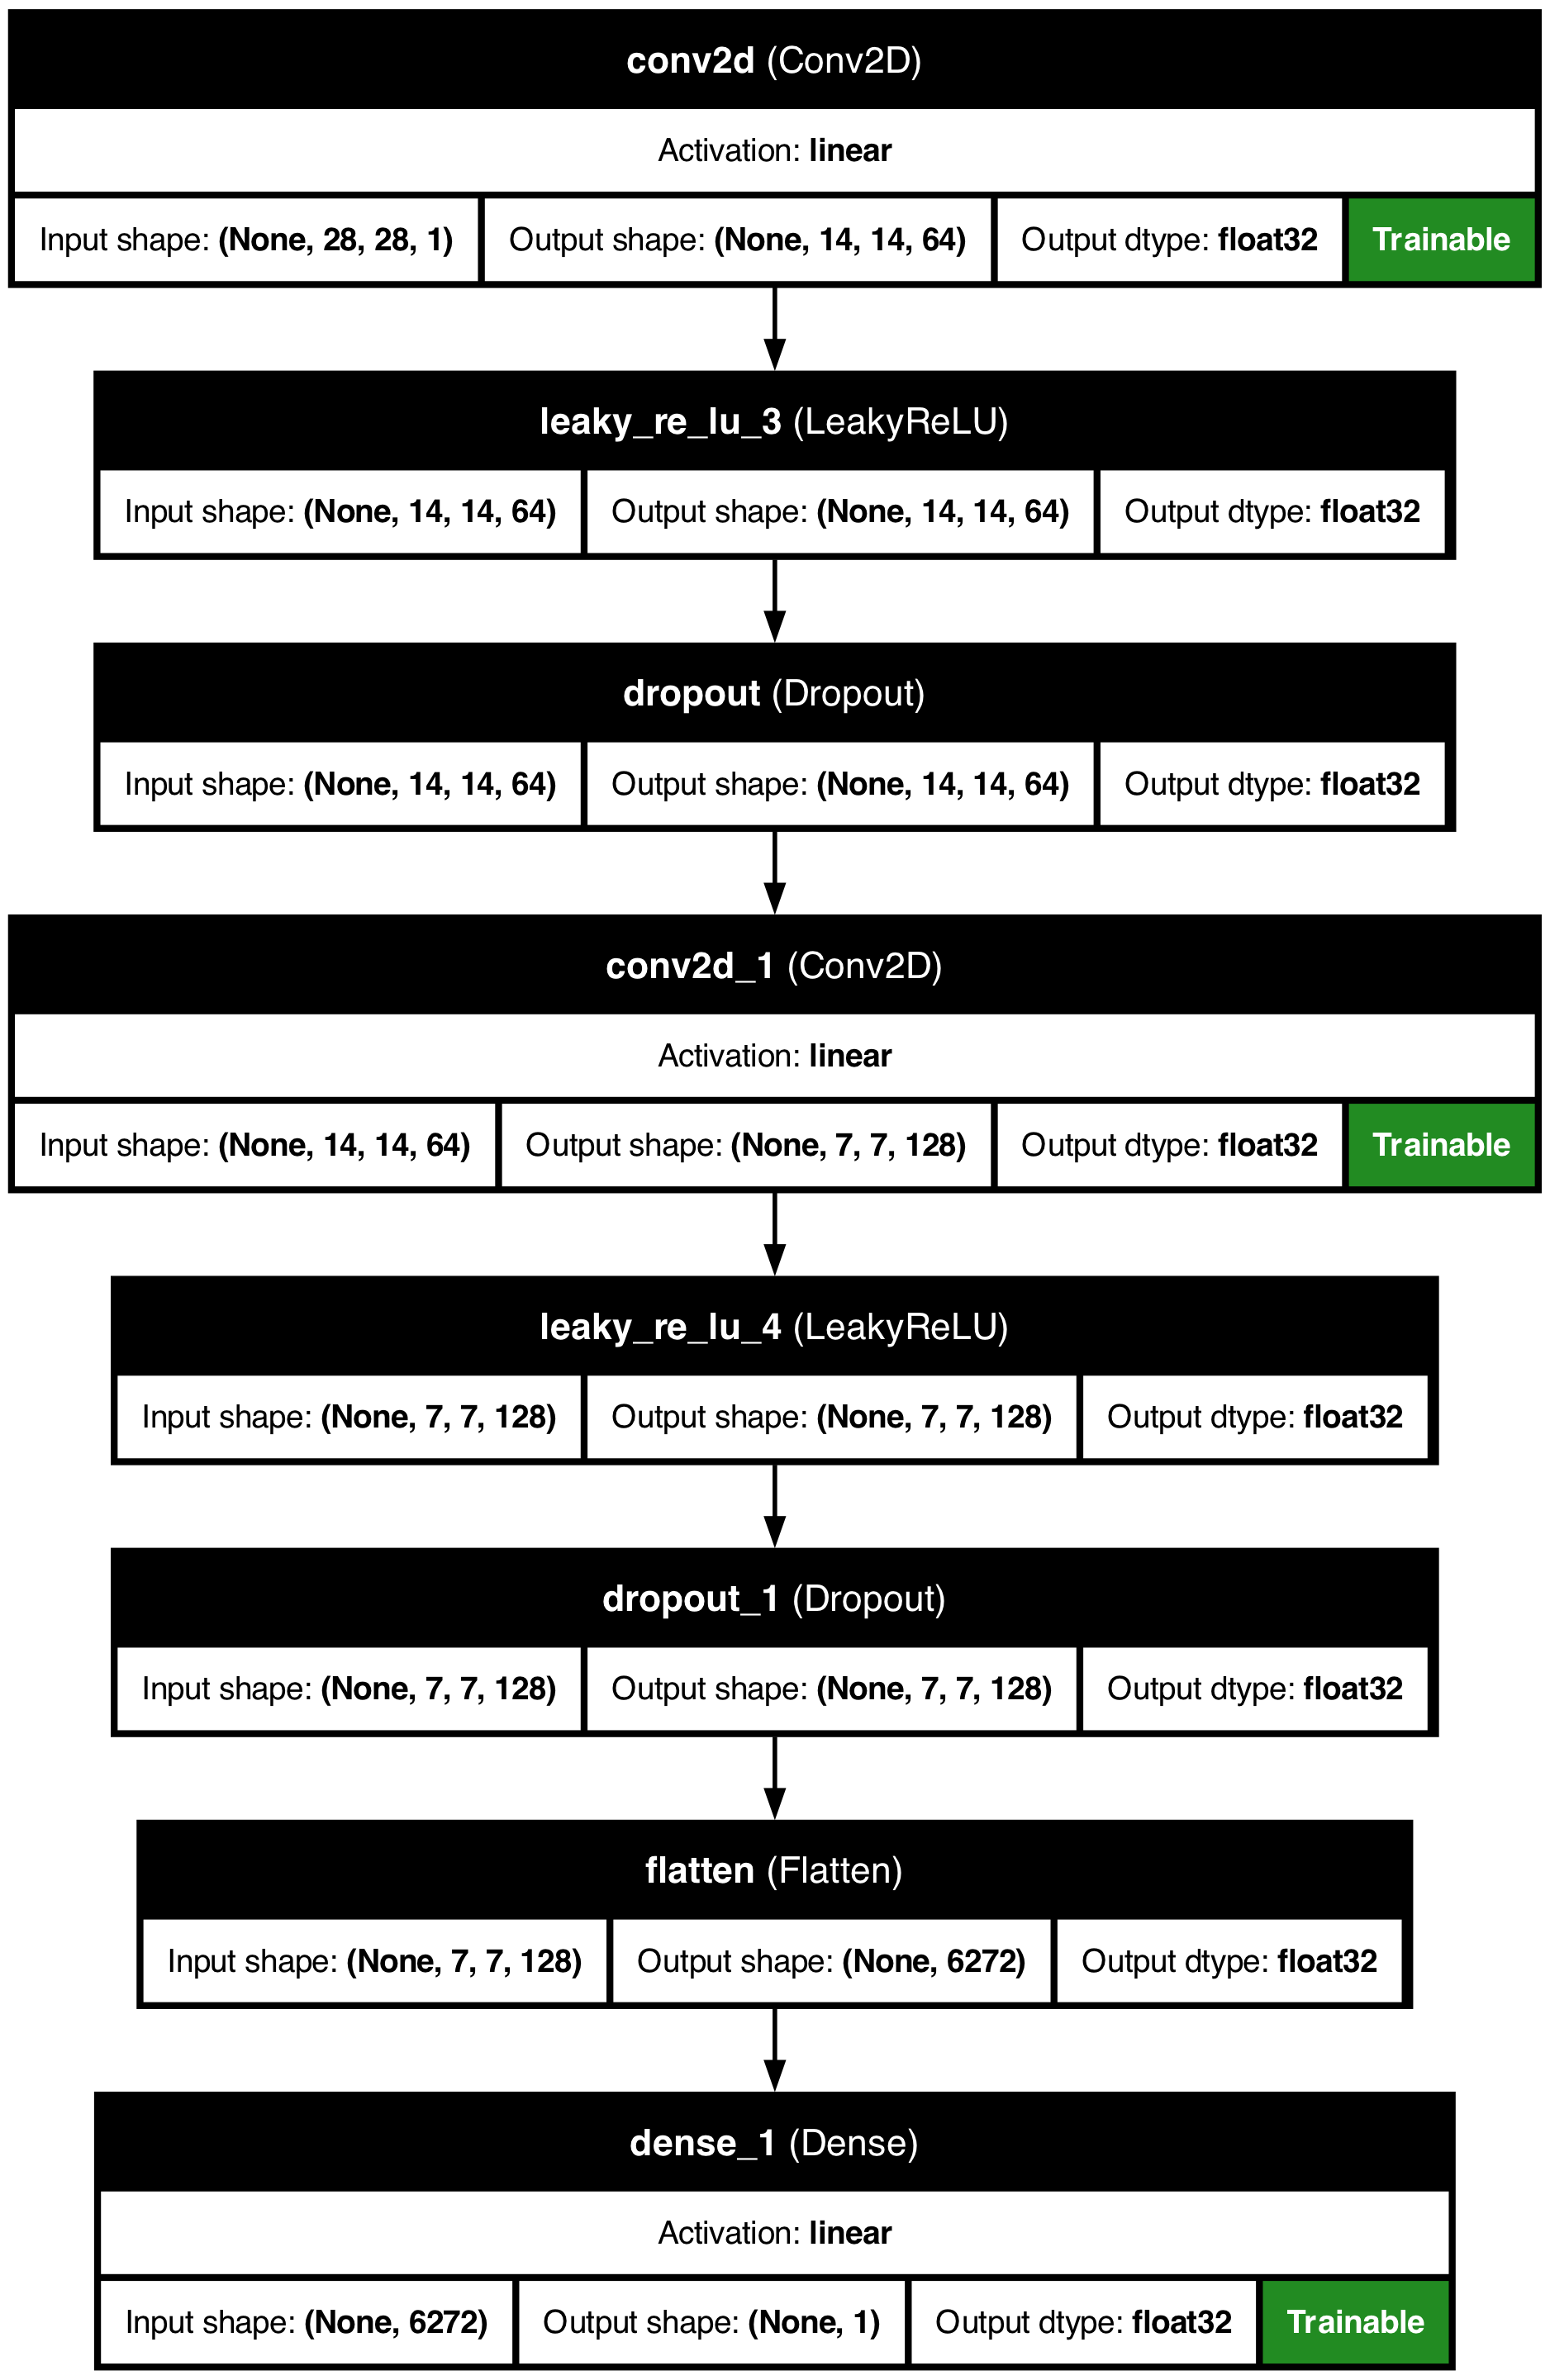

In [20]:
tf.keras.utils.plot_model(
    discriminator,
    rankdir='TB',
    show_shapes=True,
    show_layer_names=True,
    show_dtype=True,
    show_layer_activations=True,
    show_trainable=True
)

## Ottimizzatori e funzioni di costo

Avendo due modelli, dobbiamo definire gli ottimizzatori e le funzioni di costo di entrambi.

### Discriminator

In uscita dalla rete, non abbiamo una decisione a valle di una attivazione softmax o sigmoid, ma dei valori che, in gergo di Keras, sono indicati come **logits** ([spiegazione](https://stackoverflow.com/questions/57253841/from-logits-true-and-from-logits-false-get-different-training-result-for-tf-loss/71365020#71365020)). Leghiamo una variabile a questa funzione di costo:


In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Ora creiamo una nostra funzione di costo per avere una misura combinata di quanto bene riconosciamo le immagini vere e quanto bene riconosciamo quelle false. Le immagini vere le confrontiamo con degli 1, mentre quelle false con degli 0:

In [22]:
def discriminator_loss(real_output, fake_output):
    """
    Funzione di costo del discrminatore. Combina la cross-entropia per immagini vere (confrontate con degli 1) e per immagini false (confrontate con degli 0).
    :param real_output: uscite corrispondenti a immagini vere
    :param fake_output: uscite corrispondenti a immagini false
    :return: costo combinato
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Per l'ottimizzazione, ricorriamo all'algoritmo Adam con learning rate pari a 0.0001:

In [23]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Generator

Il generatore deve essere valutato in base a quanto è in grado di ingannare il discriminatore. Concettualmente, delle prestazioni buone corrispondono a situazioni in cui il discrminatore fornisce degli 1 (immagine vera) quando in realtà era uno 0 (immagine falsa). Usiamo quindi di nuovo la funzione per la cross-entropia, ma confrontando gli output delle immagini false con degli 1:

In [24]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Per l'ottimizzazione, ricorriamo di nuovo ad un algoritmo Adam con learning rate pari a 0.0001:

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Checkpoint di salvataggio

Quando si addestrano delle reti complesse, può convenire salvare lo stato parziale durante l'addestramento in caso dovessero verificarsi dei crash inaspettati o altri problemi. Questo può essere fatto ricorrendo ai [training checkpoint](https://www.tensorflow.org/guide/checkpoint):

In [26]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Addestramento

Per addestrare le reti, definiamo il numero di epoche, la dimensione dell'input (che deve essere coerente con quanto usato nel creare il generatore) e il numero di immagini false da generare per iterazione:


In [27]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Il seed definito sopra rappresenta il latent space da cui andremo a creare le immagini.

L'addestramento inizia con il generatore che prende un seed in ingresso, che viene poi usato per generare un'immagine falsa. A questo punto, il discriminatore viene utilizzato per classificare le immagini vere (dal training set) e quelle false (dal generatore). Si calcolano le funzioni di costo e si utilizzano i gradienti per aggiornare i loro pesi.

Alcune osservazioni su questo codice:
- il decoratore [**@tf.function**](https://www.tensorflow.org/guide/function) fondamentalmente trasforma le funzioni di Python in operazioni su grafi, consentendo a TensorFlow di compilare e ottimizzare il calcolo della funzione con una maggiore efficienza, soprattutto con attività/comandi ripetitivi;
- [**tf.GradientTape**](https://www.tensorflow.org/api_docs/python/tf/GradientTape) è un oggetto che permette di gestire le operazioni di differenziazione, che nel nostro caso sono due (una per il generatore e una per il decoratore) e dedicate all'aggiornamento dei pesi con gradient descent;
- il metodo [**gradient**](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) calcola il gradiente dagli oggetti GradientTape;
- il metodo [**apply_gradients**](https://keras.io/2.16/api/optimizers/) aggiorna i pesi di un oggetto Optimizers.

In [28]:
@tf.function
def train_step(images):
    """
    Questa funzione definisce uno step dell'addestramento
    :param images: immagini vere in ingresso
    :return: None
    """
    # creazione dell'array di rumore per la generazione di immagini false
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # registriamo i gradienti in fase di addestramento
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # creiamo le immagini false, indicando che vogliamo addestrare il generatore
        generated_images = generator(noise, training=True)
        # calcoliamo le uscite del discriminatore, di nuovo indicando l'addestramento
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        # calcoliamo i costi
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # calcoliamo i gradienti
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # applichiamo i gradienti
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Ora creiamo una funzione per l'addestramento:
- aa

In [29]:
def train(dataset, epochs):
    """
    Funzione per addestrare la GAN
    :param dataset: training set
    :param epochs: numero di epoche
    :return: None
    """
    # iterazione sulle epoche
    for epoch in range(epochs):
        start = time.time()  # tracciamo i tempi di esecuzione

        # iterazione sul batch in ingresso
        for image_batch in dataset:
            train_step(image_batch)  # step di addestramento come definito sopra

        # Creiamo le immagini col seed fisso: ci permette di vedere l'evoluzione della rete
        display.clear_output(wait=True)  # reset dell'output della cella
        generate_and_save_images(generator, epoch + 1, seed)
    
        # Salviamo il modello ogni 15 epoche
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        # Stampiamo il tempo di calcolo per questa epoca
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generazione delle immagini finali
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

La funzione generate_and_save_images si occupa appunto di creare e salvare le immagini:


In [30]:
def generate_and_save_images(model, epoch, test_input):
    """
    Questa funzione prende il modello in ingresso, indica che non lo si deve allenare e produce delle immagini.
    :param model: modello
    :param epoch: epoca di addestramento
    :param test_input: input della rete
    :return: None
    """
    # calcoliamo le predizioni
    predictions = model(test_input, training=False)

    # creiamo le figure
    _ = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

A questo punto, chiamiamo la funzione train() per addestrare generatore e discriminatore della nostra GAN:

In [31]:
train(train_dataset, EPOCHS)

Per vedere come i checkpoint funzionano, carichiamo l'ultimo stato:

In [32]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Creazione di una GIF

Per vedere come evolve l'addestramento della rete, creiamo una GIF. Prima di tutto, creiamo una funzione che, presa l'epoca in ingresso, ritorna l'immagine salvata:


In [33]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

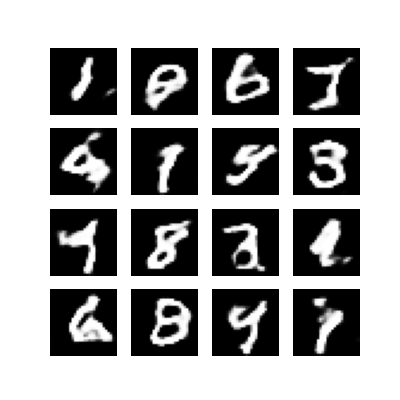

In [34]:
display_image(EPOCHS)

Ora utilizziamo [imageio](https://pypi.org/project/imageio/) per creare la GIF; il funzionamento è simile a quello della scrittura su file, ma scriviamo su una immagine:

In [35]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

/var/folders/xq/pwrk1_wx4hd5tcdxz483541w0000gn/T/ipykernel_92513/235159612.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/xq/pwrk1_wx4hd5tcdxz483541w0000gn/T/ipykernel_92513/235159612.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Importiamo [tensorflow_docs](https://pypi.org/project/tensorflow-docs/) per inserire la GIF nel notebook:


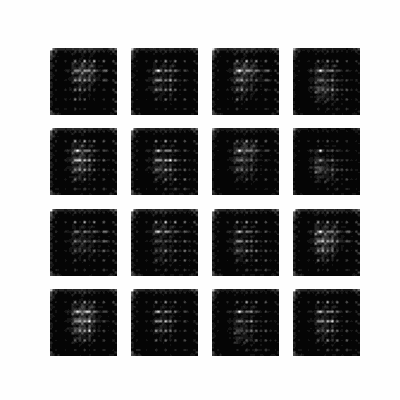

In [36]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)